# 浙江省第四类故障预测

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
%matplotlib inline

# Data Explore

In [2]:
data = pd.read_csv('./data/zhejiang_4.csv', dtype={0:object, 'ORG':object, 'SPEC_CODE':object, 'MANUFACTURER':object,
                                                  'FAULT_MONTH':int, 'INST_MONTH':object, 'FAULT_QUARTER':object, 'FAULT_TYPE': object,
                                                 }, encoding='utf-8')

#preview the zhejiang_4 data
data.head()

,﻿QUIP_ID,ORG,SPEC_CODE,MANUFACTURER,month,FAULT_MONTH,INST_MONTH,FAULT_QUARTER,FAULT_TYPE
0,8.1000000106807E+015,33403,102,10019,0,12,12,4,409
1,8.10000001068071E+015,33403,102,10019,0,12,12,4,409
2,8.10000001068071E+015,33403,102,10019,0,12,12,4,408
3,8.10000001068039E+015,33402,102,10019,0,12,12,4,411
4,8.10000001068481E+015,33403,,10019,0,12,12,4,408


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186437 entries, 0 to 186436
Data columns (total 9 columns):
﻿QUIP_ID         186437 non-null object
ORG              186437 non-null object
SPEC_CODE        186437 non-null object
MANUFACTURER     186437 non-null object
month            186437 non-null int64
FAULT_MONTH      186437 non-null int64
INST_MONTH       186437 non-null object
FAULT_QUARTER    186437 non-null object
FAULT_TYPE       186437 non-null object
dtypes: int64(2), object(7)
memory usage: 14.2 MB


# feature preprocessing

In [4]:
#delete QUIP_ID
#data.drop([data.columns[0]], axis=1, inplace=True)

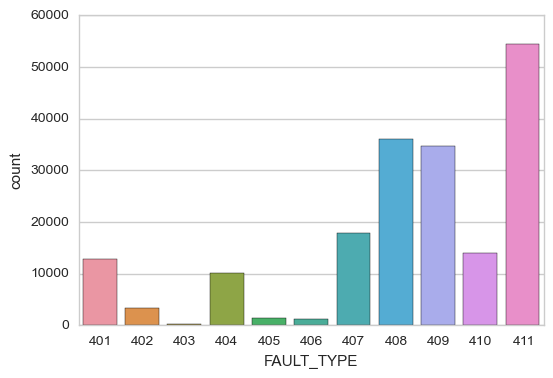

In [5]:
fig, axis0 = plt.subplots(1, 1)
sns.countplot(x='FAULT_TYPE', data=data, ax=axis0)

从故障类型柱状图可以看出故障类型数据不平衡，402-406较少，407-411较多

## ORG

/usr/lib/python2.7/dist-packages/pandas/core/index.py:2889: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1
/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


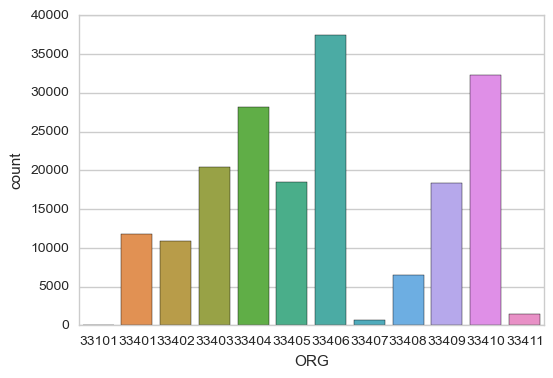

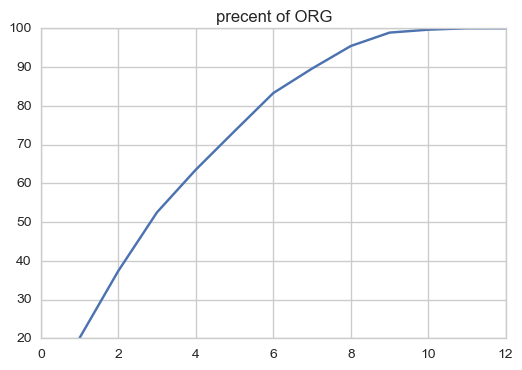

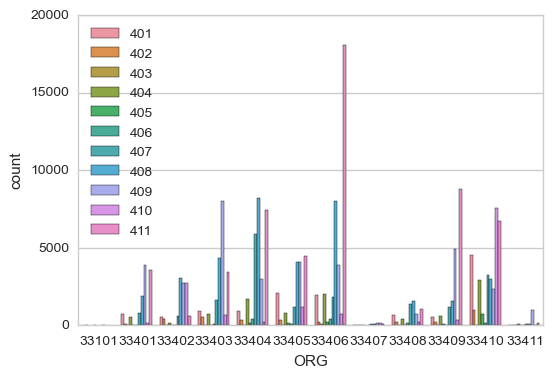

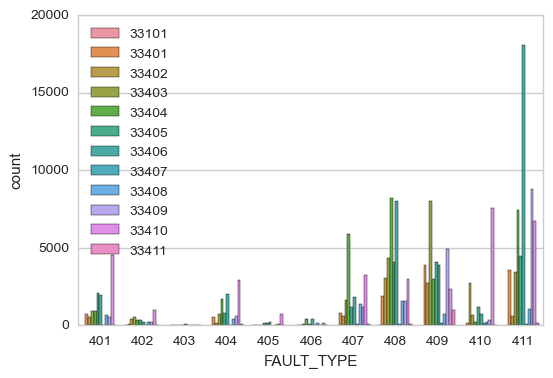

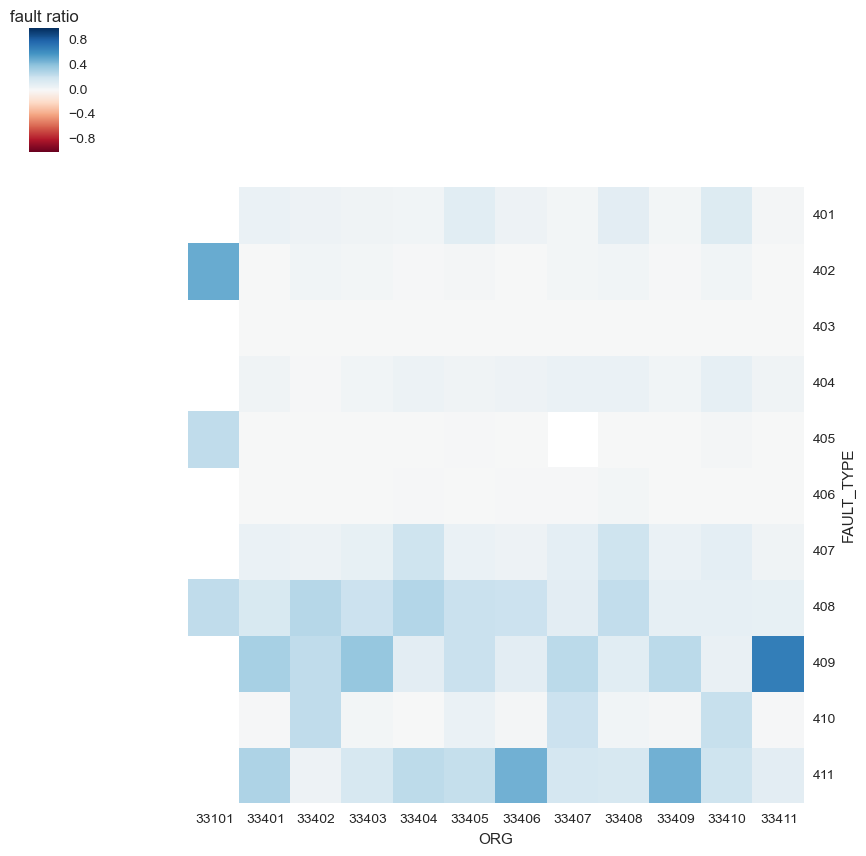

In [6]:
#ORG
data['ORG'].describe()
#plot
def plot_fun(name_fea, name_fault, fontsize=None):
    
    fig, axis1 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, data=data, ax = axis1)

    fig, axis2 = plt.subplots(1, 1)
    c = data[name_fea].value_counts()
    s = c.cumsum()/c.sum()
    axis2.plot(np.arange(s.shape[0])+1, s.values*100)
    axis2.set_title('precent of %s'%name_fea)

    fig, axis3 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, hue=name_fault, data=data, ax=axis3)
    plt.legend(loc = 2)

    fig, axis4 = plt.subplots(1, 1)
    sns.countplot(x=name_fault, hue=name_fea, data=data, ax=axis4)
    plt.legend(loc = 2, fontsize=fontsize)

    #calculate similar score
    from scipy.cluster.hierarchy import dendrogram, linkage    
    #clustermap

    fault_num1 = data.groupby([name_fault, name_fea])[data.columns[0]].count().unstack()

    ratio = fault_num1 / fault_num1.sum()  

    g1 = sns.clustermap(ratio, 
                        cmap=plt.get_cmap('RdBu'),
                        vmax=1,
                        vmin=-1,
                        linewidth=0,
                        figsize=(10, 10),
                        row_cluster=False,
                        col_cluster=False
                    )
    plt.title('fault ratio')

#plot
plot_fun('ORG', 'FAULT_TYPE')
#get_dummies
ORG_dummies = pd.get_dummies(data['ORG'])
ORG_dummies.drop(['33101', '33407', '33411'], axis=1, inplace=True)

data = data.join(ORG_dummies)
#data.drop(['ORG'], axis=1, inplace=True)
del ORG_dummies

## ORG故障类型统计
- 各个地区的故障数量不同，前8个到95%
- 从ORG与FAULT_TYPE统计图可以看出，不同地区的故障类型分布有所不同，所以认为ORG对于FAULT_TYPE类型的识别是有用的。
- 故障类型分布图显示了每个地区的故障类型占比
- 有几个地区故障类型数据较少[33101,33407,33411]，对于故障类型识别用处不大，删除
- 对属性做了二元变换处理

## SPEC_CODE

In [7]:
#SPEC_CODE
data['SPEC_CODE'].describe()

count     186437
unique         7
top          102
freq      163147
Name: SPEC_CODE, dtype: object

In [8]:
data['SPEC_CODE'].value_counts()


102    163147
118     18929
131      2560
121      1664
129       109
103        27
            1
dtype: int64

In [9]:
data.drop(data[data['SPEC_CODE']==data['SPEC_CODE'].value_counts().index[-1]].index.values, axis=0, inplace=True)

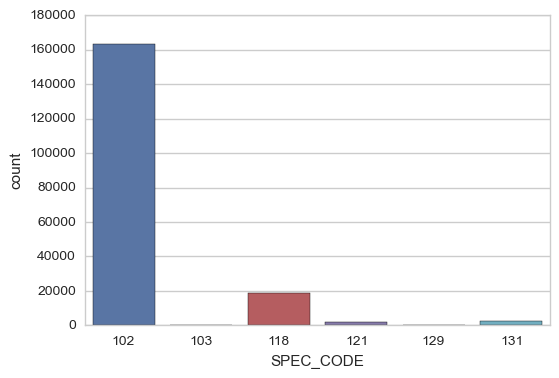

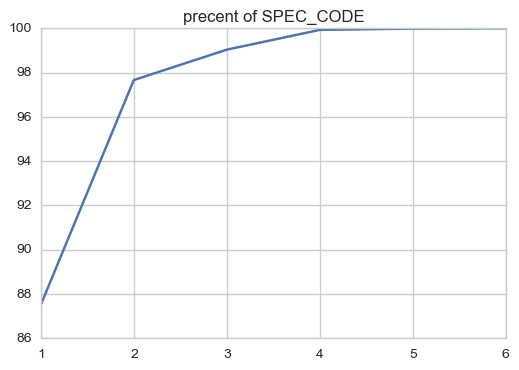

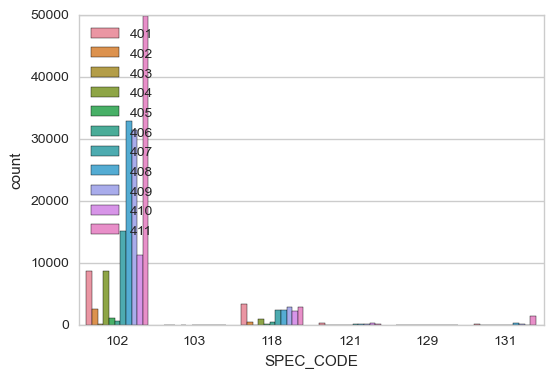

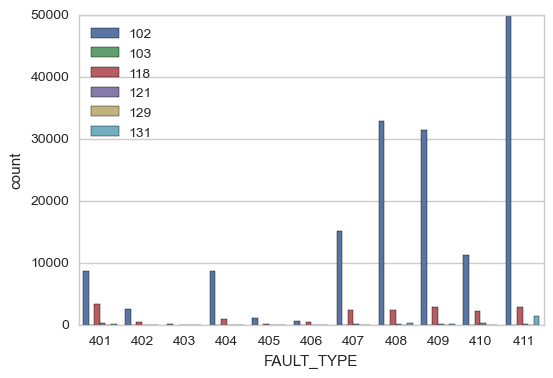

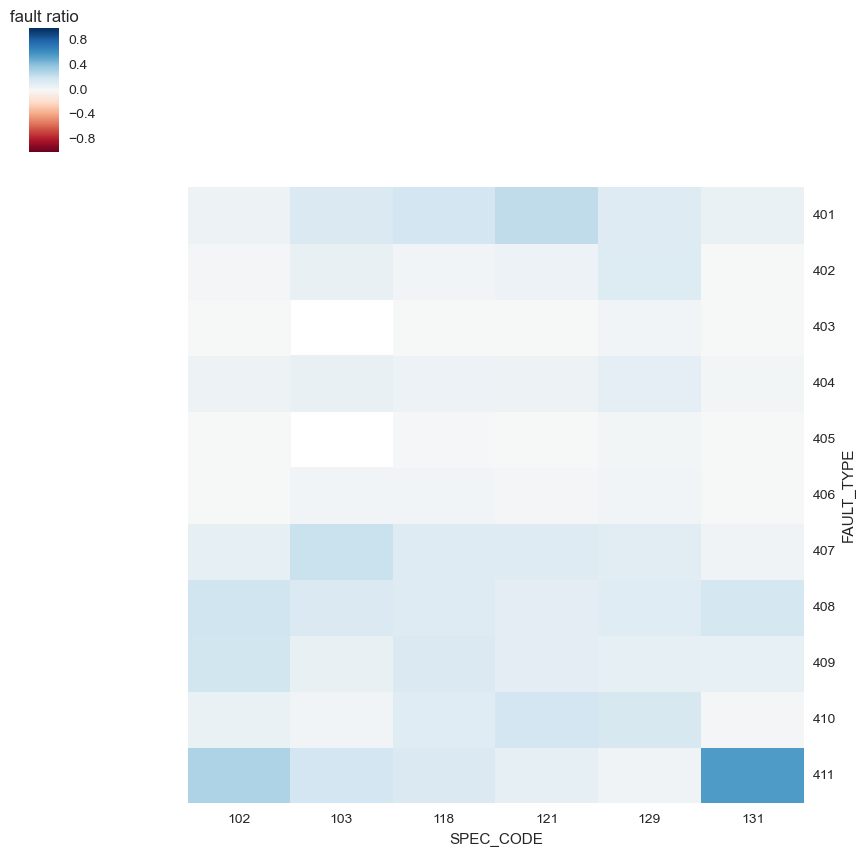

In [10]:
#plot
plot_fun('SPEC_CODE', 'FAULT_TYPE')

#get_dummies
SPEC_dummies = pd.get_dummies(data['SPEC_CODE'])

SPEC_dummies.drop(['103', '121', '129', '131'], axis=1, inplace=True)

data = data.join(SPEC_dummies)
data.drop(['SPEC_CODE'], axis=1, inplace=True)


## SPEC_CODE故障类型统计
- SPEC_CODE故障类型同样呈现分布不均匀状态
- 前两类设备类型数据达到98%
- 每种故障类型的SPEC_CODE基本相似
- 故障类型分布图显示了每种SPEC_CODE故障类型占比
- 删除极少出现的SPEC_CODE故障类型
- 对属性进行二元变换

# MANUFACTURER

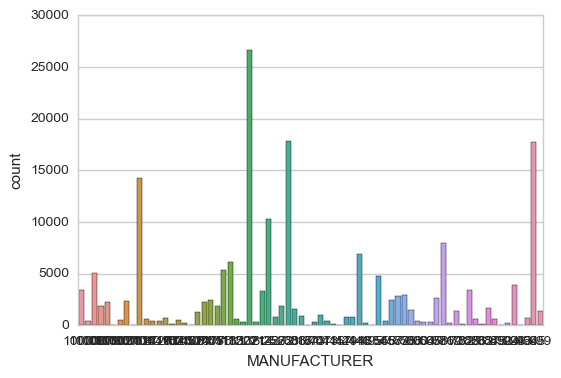

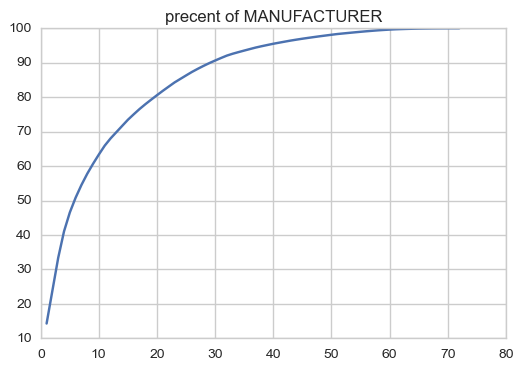

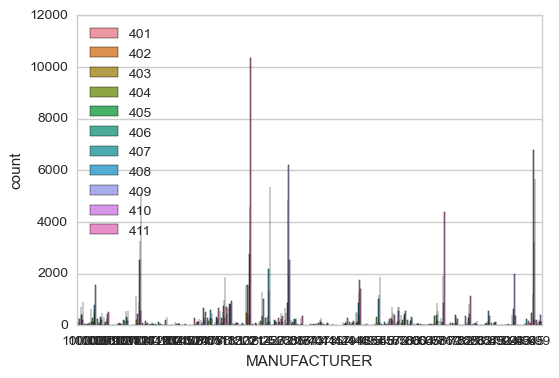

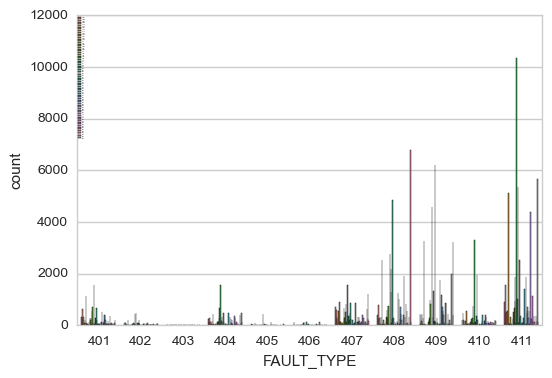

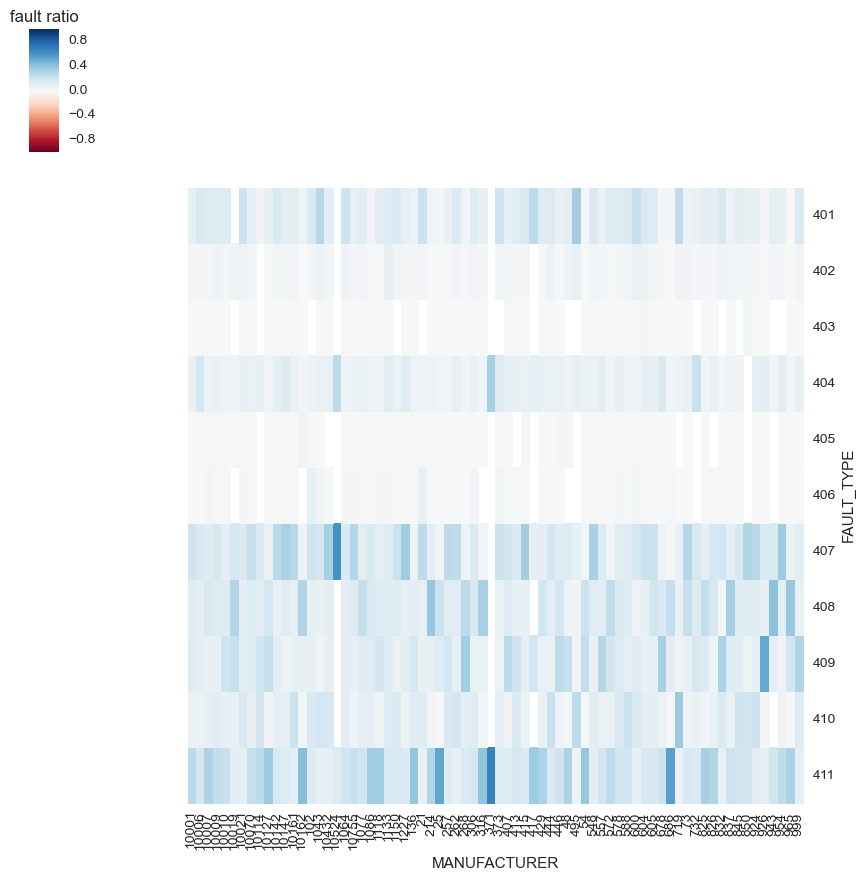

In [11]:
#plot
plot_fun('MANUFACTURER', 'FAULT_TYPE', fontsize=1)

#cluster encoding
from scipy.cluster.hierarchy import fclusterdata
fault_num3 = data.groupby(['FAULT_TYPE', 'MANUFACTURER'])[data.columns[0]].count().unstack()

MAN_ratio = fault_num3 / fault_num3.sum()
MAN_ratio_T = MAN_ratio.T

clusters = fclusterdata(np.array(MAN_ratio_T), 1)
clusters_mapping = {label:idx for label,idx in zip(MAN_ratio.columns, clusters)}


data['MANUFACTURER'] = data['MANUFACTURER'].map(clusters_mapping)

#get_dummies
MAN_dummies = pd.get_dummies(data['MANUFACTURER'])
data = data.join(MAN_dummies)
data.drop(['MANUFACTURER'], axis=1, inplace=True)

del MAN_ratio, MAN_ratio_T, clusters, clusters_mapping, MAN_dummies

## MANUFACTURER故障类型统计
- MANUFACTURER故障类型同样呈现分布不均匀状态,浙江省一共有80家供应商，电表数前30家占90%
- 前两类故障类型数据达到98%
- 每种故障类型的供应商分布不同
- 故障类型分布图显示了每种供应商故障类型占比，应用分层聚类方法将具有相似故障类型分布的供应商进行合并
- 对属性进行二元变换

# MONTH

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f99fd75c090>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f99fc52cd90>], dtype=object)

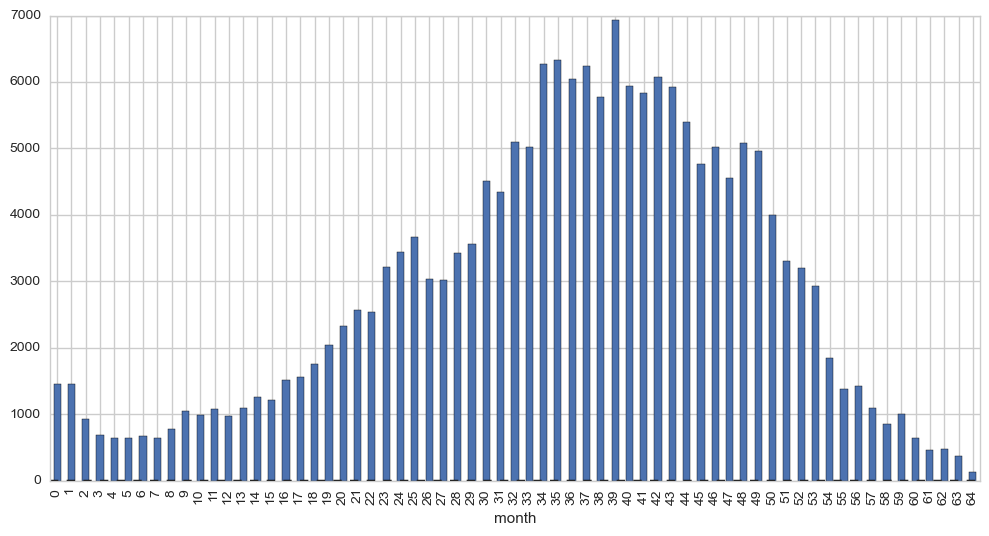

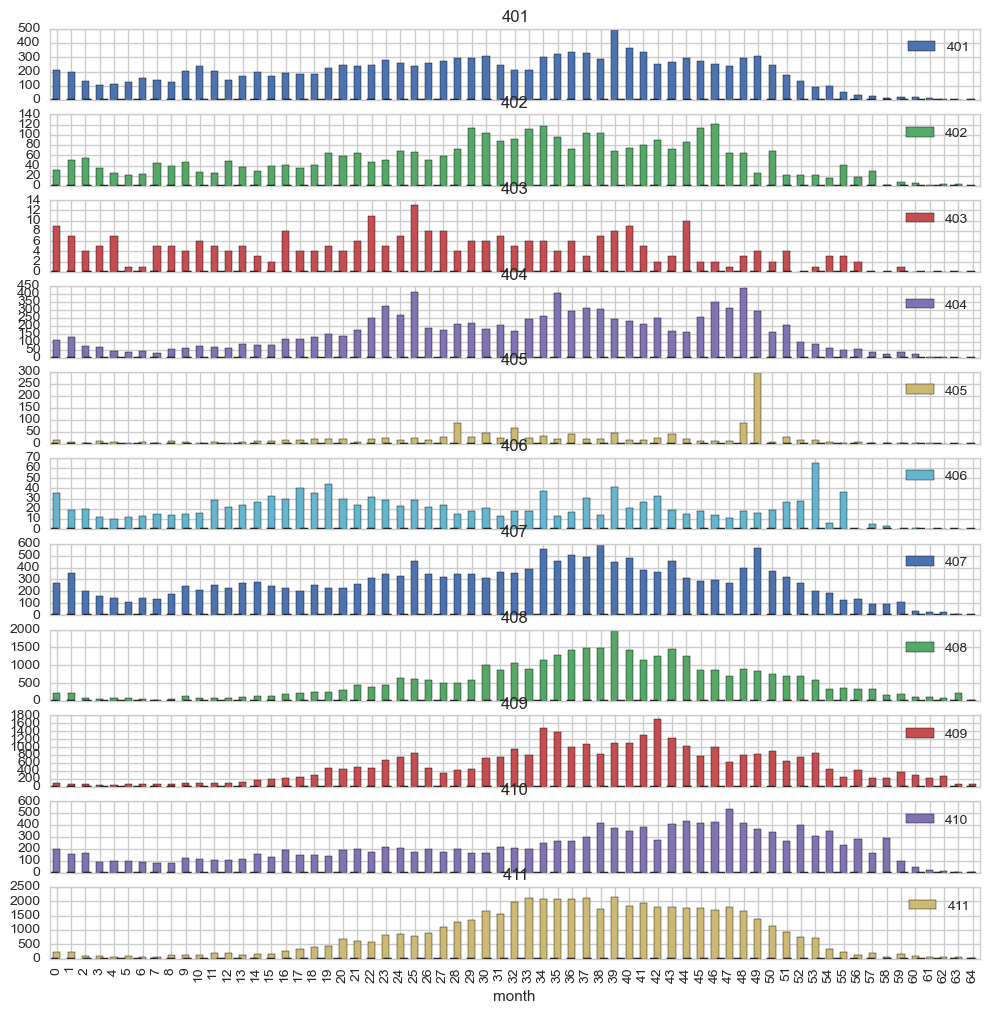

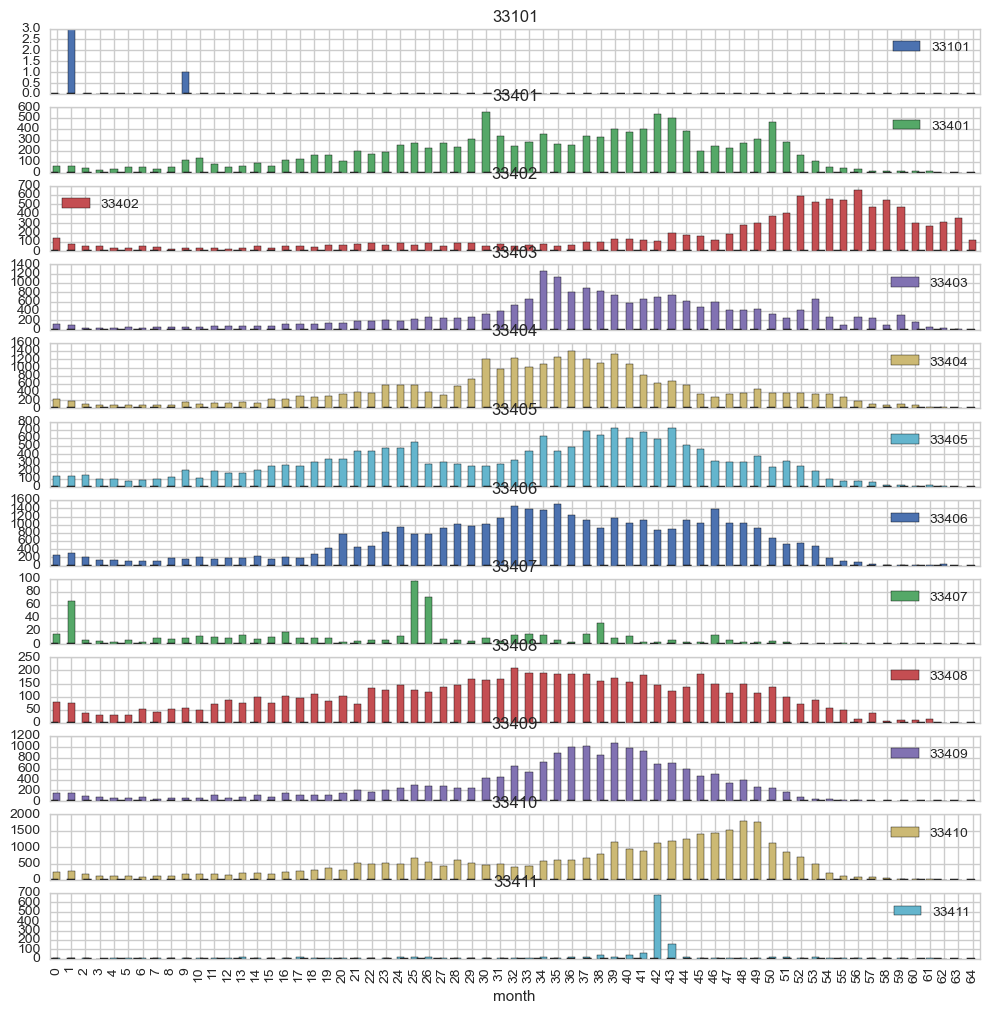

In [12]:
# use month distribution
c1 = data.groupby(['month']).size()
c1.plot(kind='bar', figsize=(12, 6))

c2 = data.groupby(['month', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c2.plot(kind='bar', figsize=(12, 12), subplots=True)

c3 = data.groupby(['month', 'ORG']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c3.plot(kind='bar', figsize=(12, 12), subplots=True)

## 使用寿命-故障类型统计
- 对浙江省故障电表使用寿命进行了统计，可看出其分布基本为正态分布，符合客观规律。
- 使用寿命-故障类型图显示了每种故障类型的使用寿命分布情况，基本为正态分布，但是其分布参数有所不同，可以用来作为分类特征。
- 使用寿命-供电所分布图，不同供电所的使用寿命分布有区别，可以得出供电所对电表使用寿命有影响。

## FAULT_MONTH

[29 30 21 21 26 27 28 24 23 22 25 22]


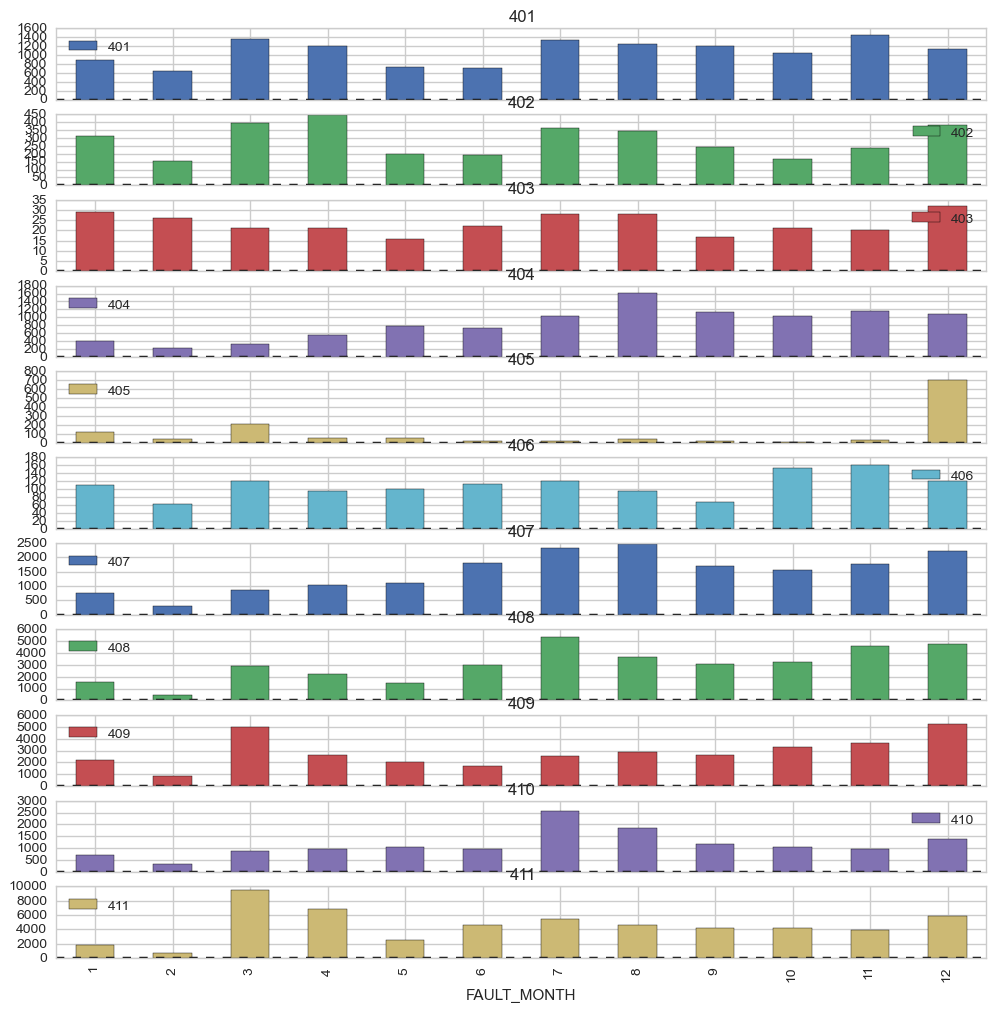

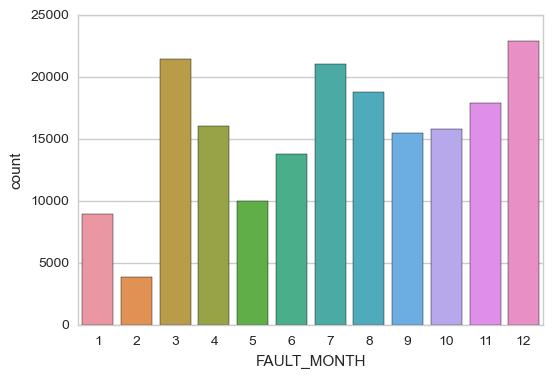

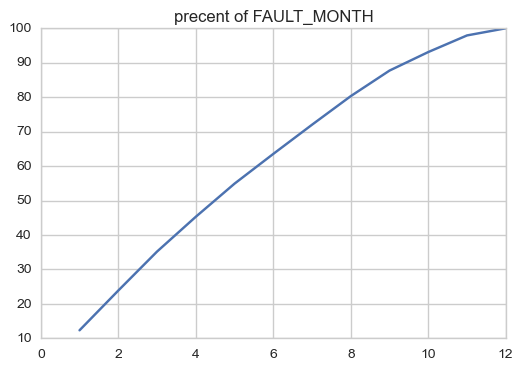

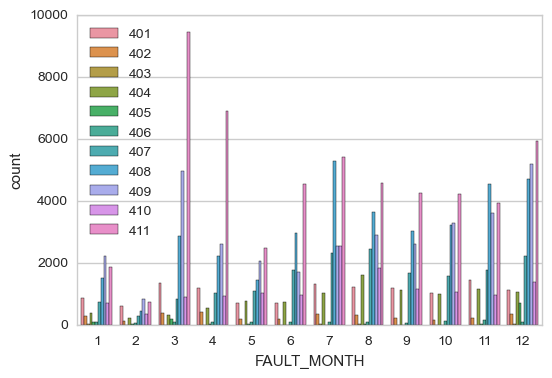

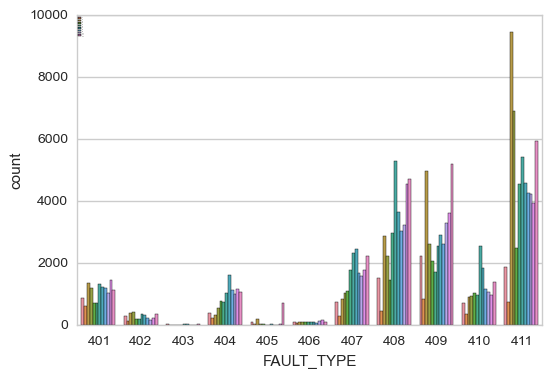

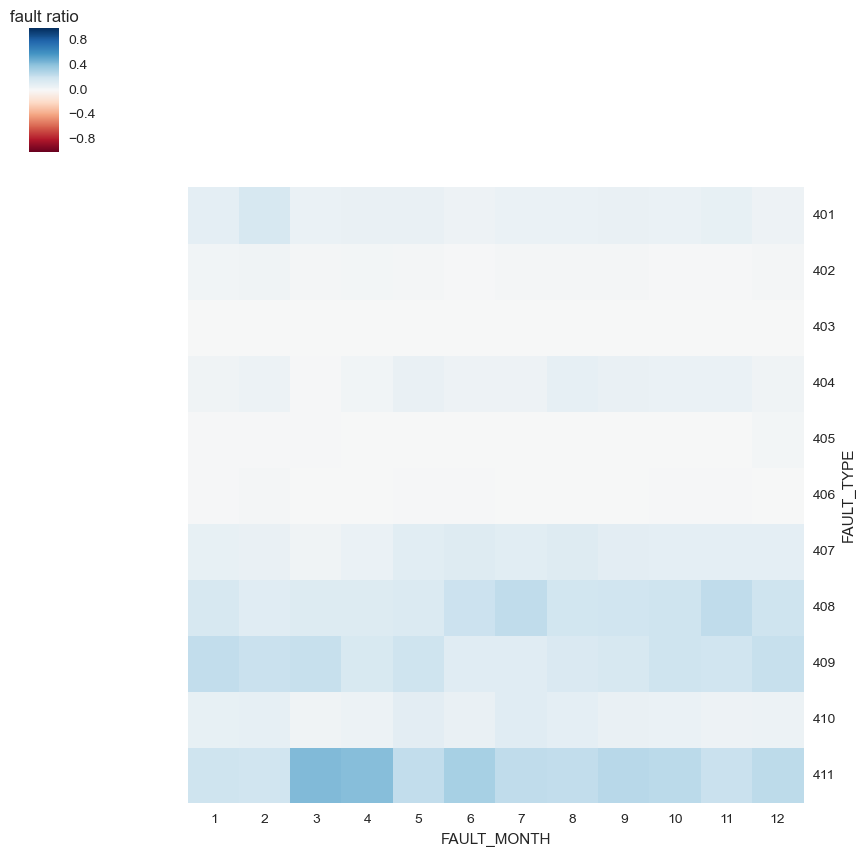

In [13]:
data['FAULT_MONTH'] = pd.Categorical(data['FAULT_MONTH'], ordered=True)

m1 = data.groupby(['FAULT_MONTH', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.FAULT_MONTH.min(), data.FAULT_MONTH.max()+1)).fillna(0)
m1.plot(kind='bar', figsize=(12, 12), subplots=True)
plot_fun('FAULT_MONTH', 'FAULT_TYPE', fontsize=1)

fault_num4 = data.groupby(['FAULT_TYPE', 'FAULT_MONTH'])[data.columns[0]].count().unstack()

FAUMON_ratio = fault_num4 / fault_num4.sum()
FAUMON_ratio_T = FAUMON_ratio.T

clusters = fclusterdata(np.array(FAUMON_ratio_T), 0.70)
clusters = clusters+20
print clusters

clusters_mapping = {label:idx for label,idx in zip(FAUMON_ratio.columns, clusters)}


data['FAULT_MONTH'] = data['FAULT_MONTH'].map(clusters_mapping)

#get_dummies
FAUMON_dummies = pd.get_dummies(data['FAULT_MONTH'])
data = data.join(FAUMON_dummies)
data.drop(['FAULT_MONTH'], axis=1, inplace=True)
del fault_num4, FAUMON_ratio, FAUMON_ratio_T, clusters, clusters_mapping, FAUMON_dummies

## 故障月份-故障类型统计
- 故障月份-故障数量统计表显示了不同月份故障数量的分布，分布不是很均匀
- 故障月份-故障类型图显示了每月的故障类型分布情况，每个月的故障类型占比基本相似，是比较弱的分类特征。
- 故障月份-故障类型分布图，不同月份故障类型占比基本相似。

## 机器学习算法故障预测

In [14]:
data.drop(['ORG','INST_MONTH', 'FAULT_QUARTER'], axis=1, inplace=True)

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
data_X = data.drop(['FAULT_TYPE', data.columns[0]], axis=1)
data_y = data['FAULT_TYPE']
#encode label
le = preprocessing.LabelEncoder()
data_y = le.fit_transform(data_y)
train, test, train_y, test_y = train_test_split(data_X, data_y, test_size=0.33, random_state=27)

# XGBoost

[0]	train-merror:0.540436+0.00735802	test-merror:0.560787+0.00553292
[1]	train-merror:0.517016+0.00240854	test-merror:0.540733+0.00216658
[2]	train-merror:0.508946+0.00207472	test-merror:0.533503+0.00194361
[3]	train-merror:0.503018+0.00061891	test-merror:0.529805+0.000831583
[4]	train-merror:0.498447+0.000823566	test-merror:0.526026+0.00100975
[5]	train-merror:0.495537+0.0018179	test-merror:0.524425+0.000892865
[6]	train-merror:0.494568+0.00176357	test-merror:0.524105+0.00051387
[7]	train-merror:0.49173+0.00171644	test-merror:0.521808+0.000499428
[8]	train-merror:0.490029+0.00159972	test-merror:0.520438+0.00142851
[9]	train-merror:0.488772+0.00205485	test-merror:0.519846+0.00122884
[10]	train-merror:0.486818+0.00220264	test-merror:0.518797+0.000894526
[11]	train-merror:0.48549+0.00156187	test-merror:0.517884+0.000437851
[12]	train-merror:0.484285+0.000710219	test-merror:0.517444+0.000252595
[13]	train-merror:0.483504+0.000790225	test-merror:0.516756+0.000308316
[14]	train-merror:0.482

/home/hadoop/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        401       0.36      0.27      0.31      4230
        402       0.34      0.08      0.13      1169
        403       0.00      0.00      0.00        99
        404       0.43      0.18      0.26      3337
        405       0.36      0.30      0.33       446
        406       0.30      0.12      0.18       422
        407       0.41      0.35      0.38      5926
        408       0.52      0.45      0.49     11874
        409       0.59      0.55      0.57     11547
        410       0.42      0.49      0.46      4539
        411       0.52      0.71      0.60     17935

avg / total       0.49      0.50      0.49     61524

[[ 1157    38     0    92     8    24   481   384   396   590  1060]
 [  149    98     0    27     2     2   134   105   113   194   345]
 [   10     0     0     2     0     0    13    13    16    15    30]
 [  218    13     0   616    13     7   388   405   369   326   982]
 [   27     0     0     4   133 

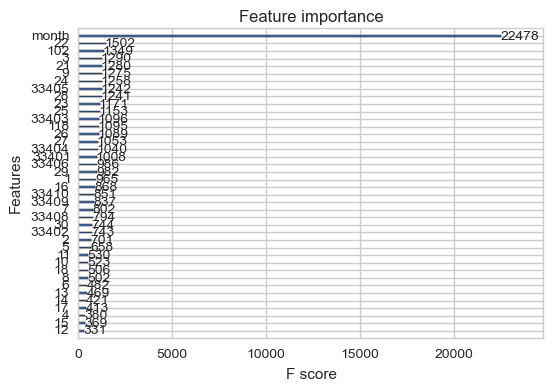

In [16]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

TRAIN = True  #是否训练

#split train set and test set
dtrain = xgb.DMatrix(train, train_y)
dtest = xgb.DMatrix(test)

clf = xgb.XGBClassifier(
    learning_rate = 0.3,
    n_estimators = 265,
    max_depth = 11,
    colsample_bytree = 0.8,
    subsample = 0.9,
    objective = 'multi:softmax',
    min_child_weight = 1,
    gamma = 2,
    seed = 27
    )

param = clf.get_xgb_params()
param['num_class'] = 11
cvresult = xgb.cv(param, dtrain, num_boost_round=1000, nfold=3, stratified=True,
                  metrics='merror', early_stopping_rounds=10,verbose_eval=True)

clf.set_params(n_estimators=cvresult.shape[0])   #set n_estimators as cv rounds
if TRAIN:
    clf.fit(train, train_y, eval_metric='merror')
else:
    clf = pickle.load(open("zhejiang_4.pkl", "rb"))
        

ypred_xgb = clf.predict(test)
ypred_xgb = le.inverse_transform(ypred_xgb)
test_y_xgb = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_xgb, ypred_xgb))
print(confusion_matrix(test_y_xgb, ypred_xgb))

xgb.plot_importance(clf.booster())
pickle.dump(clf, open("zhejiang_4.pkl", "wb"))


* 召回率(Recall)=  系统检索到的相关文件 / 系统所有相关的文件总数
* 准确率(Precision) =  系统检索到的相关文件 / 系统所有检索到的文件总数
* f1 = 2*Recall*Precision / (Recall+Precision)

In [17]:
'''
param_test1 = {'max_depth':range(5,12,2), 'min_child_weight':range(1,7,2)}
gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy',n_jobs=-1,cv=2, verbose=True)
gsearch1.fit(train, train_y)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {'max_depth':range(5,12,2), 'min_child_weight':range(1,7,2)}\ngsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy',n_jobs=-1,cv=2, verbose=True)\ngsearch1.fit(train, train_y)\nprint gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_\n"

In [18]:
data['FAULT_TYPE'].value_counts()

411    54446
408    36046
409    34713
407    17937
410    13939
401    12893
404    10082
402     3422
405     1357
406     1320
403      281
dtype: int64

# SGDClassifier
使用随机梯度下降线性分类器

对于线性不可分情况，使用rbf核将数据映射到高维空间中

In [19]:
from sklearn.kernel_approximation import RBFSampler, Nystroem

USE_RBF = False   #True：RBFSampler, False:Nystroem
if USE_RBF:
    rbf_feature = RBFSampler(gamma=1, random_state=1)
    train_SGD = rbf_feature.fit_transform(train)
    test_SGD = rbf_feature.transform(test)
else:
    Nys_feature = Nystroem(gamma=1, random_state=1)
    train_SGD = Nys_feature.fit_transform(train)
    test_SGD = Nys_feature.transform(test)
        

In [21]:
from sklearn.linear_model import SGDClassifier

USE_GridSearch = False
clf = SGDClassifier(loss='modified_huber', alpha=0.01, n_iter=100, class_weight="balanced", random_state=27)
if USE_GridSearch:
    param_test1 = {'loss':['hinge', 'log','modified_huber', 'squared_hinge', 'perceptron'], 'alpha':[0.1, 0.01, 0.01, 0.0001]}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train_SGD, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train_SGD, train_y)
ypred_sgd = clf.predict(test_SGD)
ypred_sgd = le.inverse_transform(ypred_sgd)
test_y_sgd = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_sgd, ypred_sgd))
print(confusion_matrix(test_y_sgd, ypred_sgd))
pickle.dump(clf, open("zhejiang_4_SGD.pkl", "wb"))

             precision    recall  f1-score   support

        401       0.43      0.00      0.00      4230
        402       0.00      0.00      0.00      1169
        403       0.00      0.00      0.00        99
        404       0.65      0.01      0.01      3337
        405       0.10      0.32      0.15       446
        406       0.02      0.01      0.02       422
        407       0.57      0.01      0.01      5926
        408       0.47      0.07      0.11     11874
        409       0.73      0.08      0.15     11547
        410       0.43      0.04      0.07      4539
        411       0.30      0.93      0.45     17935

avg / total       0.47      0.31      0.19     61524

[[   10     0     0     0   132     4     6    15    11    17  4035]
 [    0     0     0     0    25     0     0     1     2     1  1140]
 [    0     0     0     0     0     0     0     0     0     0    99]
 [    0     0     0    24   163     2     5    80     4    16  3043]
 [    0     0     0     0   141 

## KNN

In [23]:
from sklearn import neighbors

USE_GridSearch = False
n_neighbors = 50
 
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
if USE_GridSearch:
    param_test1 = {'n_neighbors':range(20,60,10), 'weights':['uniform', 'distance']}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train, train_y)
ypred_knn = clf.predict(test)
ypred_knn = le.inverse_transform(ypred_knn)
test_y_knn = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_knn, ypred_knn))
print(confusion_matrix(test_y_knn, ypred_knn))
pickle.dump(clf, open("zhejiang_4_KNN.pkl", "wb"))

             precision    recall  f1-score   support

        401       0.32      0.30      0.31      4230
        402       0.24      0.14      0.17      1169
        403       0.06      0.02      0.03        99
        404       0.34      0.25      0.29      3337
        405       0.34      0.34      0.34       446
        406       0.25      0.15      0.18       422
        407       0.39      0.35      0.37      5926
        408       0.51      0.47      0.49     11874
        409       0.60      0.54      0.57     11547
        410       0.44      0.43      0.44      4539
        411       0.53      0.67      0.59     17935

avg / total       0.49      0.49      0.49     61524

[[ 1289    83     8   167    17    27   455   452   351   424   957]
 [  147   161     2    53     4     9   117   120   110   141   305]
 [    8     1     2     2     0     0    23    10    18    13    22]
 [  263    38     2   830    13    13   378   438   318   224   820]
 [   25     1     1    16   152 

* XGBoost算法使用决策树作为弱分类器，如果训练数据可分的情况下将会一直拟合数据知道训练准确率100%，可以证明数据不可分
* SGDClassifier是针对数据量较大的线性分类器，当线性分类无效时，使用rbf将数据映射到高维空间中，再采用线性分类其进行分类，效果不佳
* 使用KNN算法
## 下一步计划

1. 获取供电所位置坐标信息，将其用于统计基于省、市单位的故障类型分布以及使用寿命热力分布图
2. 调研具有更加有区分度的数据，是否能再现有数据的基础上进行一些变换？
3. 利用挂装量计算未故障电表故障数据，进行电表是否发生故障预测
4. 电表使用寿命作为目标，进行电表使用寿命预测